In [1]:
%matplotlib inline

# Housing Inventory - Model

Let's get the data staged in our dataframe, again.

In [26]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import _ETL_sandbox.basic_helpers as hp
import _ETL_sandbox.queries as q


query = q.Queries()

db_name = '../../_data/housing_inventory.db'
db_con = hp.create_connection(db_name)
df = pd.read_sql_query(sql=query.main_query, con=db_con.get('con'))
hp.close_connection(db_con.get('con'))

# 1. Build the Casual Loop Diagram

Based on our EDA correlations, let's recap and stage a CLD table lookup to facilitate our analysis:

$$
\begin{aligned}
\begin{array}{ccc}
\text{Variable Name} & \text{Expected CLD sign to Housing Inventory} & \text{comment}\\
\hline
\text{housing permits} & \text{positive} & \text{More building permits mean more higher inventory} \\
\text{mortgage rate} & \text{positive} & \text{Higher mortgage rates should yield higher inventory} \\
\text{credit} & \text{negative} & \text{Higher credit showed a slight decrease in inventory} \\
\text{prime rate} & \text{positive} & \text{Slight increase in prime rate increased inventory} \\
\text{cbsa code} & \text{N/A} & \text{categorical variable for car origin}\\
\hline
\end{array}
\end{aligned}
$$

More detailed discussions of the signs of each of these is available in [Housing Inventory - Explore](Housing%20Inventory%20-%20Explore.ipynb).

# 2. Null-Model

Recapping the single variable EDA, our null model for the housing inventory looks like the following.

In [3]:
df['housing_inventory'].describe()

count    296544.000000
mean       3634.159599
std        8178.430136
min         118.000000
25%         657.000000
50%        1318.500000
75%        2963.000000
max      108702.000000
Name: housing_inventory, dtype: float64

From the empirical normal distribution, with a 95% error bounds, we would expect 95% of our values to fall in the range $\mu \pm 1.96 \sigma$.

In [4]:
null_mu = np.mean(df['housing_inventory'])
null_sd = np.std(df['housing_inventory'])
print('For our null model we expect 95% of the values to fall within the range {a} <= {b} <= {c}'.format(a = round(null_mu - 1.96 * null_sd, 2), b = round(null_mu,2), c = round(null_mu + 1.96 * null_mu,2) ))

For our null model we expect 95% of the values to fall within the range -12395.54 <= 3634.16 <= 10757.11


Obviously, we cannot have negative housing inventory, so a more pragmatic null model with 95% error bounds would be 0 <= 3634.16<= 10757.11
And to summarize for our null model:
- expected value: 3634.16
- error: 81878.64

# 3. Linear Model Development

Now let's start building our linear model. First let's do some setup for categorical variable encoding.

In [5]:
df = pd.concat([df, pd.get_dummies(df['cbsa_code'], prefix='cbsa_encoded')], axis=1)

Now, although is a repeat of our EDA, let's get the correlations en-masse for our numeric variables (thus, excluding the hundreds of cbsa regions).

In [6]:
hp.get_correlations_en_masse(data=df, y ='housing_inventory', xs = ['housing_permits', 'mortgage_rate', 'prime_rate', 'credit'])

,feature,r,rho
0,housing_permits,0.771859,0.788558
1,mortgage_rate,0.013516,0.026773
2,prime_rate,0.009512,0.030447
3,credit,-0.003588,-0.029388


## 3.1a Linear Model Development

Let's first try with all the variables.

In [7]:
cbsa_mask = ['cbsa' in x for x in df.columns]
cbsa_cols = [b for a,b in zip(cbsa_mask, df.columns) if a]

# cut-out the org cbsa_code and the last one
cbsa_cols = cbsa_cols[1:-1]
cbsa_cols = ' + '.join(cbsa_cols)

In [8]:
model1 = 'housing_inventory ~ housing_permits + mortgage_rate + credit+ prime_rate +'+cbsa_cols
result1 = hp.bootstrap_linear_regression(formula=model1, data = df)
hp.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,2905.93,2658.59,3107.36
housing_permits,$\beta_{1}$,17.00,-3.72,37.11
mortgage_rate,$\beta_{2}$,1843.81,1806.06,1881.32
credit,$\beta_{3}$,-353.94,-378.74,-332.59
prime_rate,$\beta_{4}$,-146.85,-173.34,-122.33
cbsa_encoded_10180,$\beta_{5}$,5046.21,4991.95,5117.13
cbsa_encoded_10420,$\beta_{6}$,3270.77,3232.47,3328.46
cbsa_encoded_10500,$\beta_{7}$,-279.27,-299.88,-260.95
cbsa_encoded_10540,$\beta_{8}$,3151.49,3073.64,3201.78


Our mean error was just 1488.35, a substantial improvement from 8178.64 in our null model. Moreover, the $R^2$ is already an astoundingly good 97%! Only downside... this is a _very_ precise model that functionally requires the population of very sparse matrix.  Let's take a different route where we instead generalize without the `cbsa code` in the model generation process at all.

## 3.1b Linear Model Development

Let's try again without the `cbsa codes`.

In [9]:
df = df.drop(df.filter(regex='cbsa_encoded*').columns, axis=1)

In [10]:
model2 = 'housing_inventory ~ housing_permits + mortgage_rate + credit + prime_rate'
result2 = hp.bootstrap_linear_regression(formula=model2, data = df)
hp.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,3970.72,3457.77,4535.40
housing_permits,$\beta_{1}$,10.36,10.25,10.49
mortgage_rate,$\beta_{2}$,272.94,211.41,339.54
credit,$\beta_{3}$,-0.01,-0.01,-0.00
prime_rate,$\beta_{4}$,181.88,139.79,227.81
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,5194.02,5135.92,5260.58,
$R^2$,0.60,0.59,0.60,


Ok, our mean error isn't a good as the first model, 5194.67 vs. 1488.35, but it is still far better than our null model's error of 81878.64. Our coefficient of determination, $R^2$ took a big hit, though, at 0.60 vs. 0.97. This model is far easier to use, though.  This said, let's work to improve that $R^2$.

**Coefficient Analysis**

Given that our CLD is focused just on `housing permits`, `mortgage rates`, `credit`, and `prime rate`, let's focus on those first. Let's bring the Gelman table up for reference:
![Gelman table](images/Rule%20of%20Thumb%20examining%20coefficients%20and%20credible%20bounds.jpeg)

For `housing permits` was expected to be positive, and it had strong evidence supporting this. We will retain `housing permits` accordingly. `mortgage rate` as well, was expected to be positive, and it was positive with strong supporting evidence. Let's retain in as well. `credit` was expected to be negative and was negative; however, the evidence was very weak and it did include zero. Following Gelman's advice, though; let's retain the `credit` variable. Lastly, for `prime_rate`, we expected it to be positive, and it was positive; however, the data was mixed in the support for this. Following guidance, though, let's retain `prime_rate` as well.


**Residual Analysis**

Given the CLD analysis indicated we should retain all the variables, let's look at the residuals to see if any trends present that we can leverage to improve the model.

`housing_permits` doesn't look so great. While it is symmetric, the distinctive cone of heteroscedasticity is present. This means that there is a substantial variance for `housing_permits` with respect to the housing inventory. A more in-depth approach like _weighted-least squares_ might be an appropriate remedy for future analyis, but let's leave it as-is for this analysis.[1] `mortgage_rate`, `credit`, and `prime_rate` all have similar shapes and some tendencies toward symmetry. We say "tendencies toward symmetry" as all three variables have higher positive residual maximums but have denser negative residuals across their respective domains. At a minimum, let's try adding some interaction terms to see if that might capture correlations. From domain knowledge, we clearly anticipate a strong correlation between the prime-rate and the mortgage rate, but the residual plots indicate we should also include `credit` when we look at variable interactions.



## 3.1c Linear Model Development

Let's try adding a single interaction term between the `mortgage_rate` and `prime_rate`.

In [11]:
model3 = 'housing_inventory ~ housing_permits + mortgage_rate + credit + prime_rate + mortgage_rate:prime_rate'
result3 = hp.bootstrap_linear_regression(formula=model3, data = df)
hp.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-4382.77,-5364.67,-3622.68
housing_permits,$\beta_{1}$,10.37,10.24,10.53
mortgage_rate,$\beta_{2}$,2755.35,2594.90,2986.88
credit,$\beta_{3}$,-0.01,-0.01,-0.01
prime_rate,$\beta_{4}$,2998.07,2742.30,3243.51
mortgage_rate:prime_rate,$\beta_{5}$,-700.03,-762.68,-647.33
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,5190.10,5112.06,5261.09,


Including the interaction term between `mortgage_rate` and `prime_rate` lowered the error minutely, from 5194 from 5190, but the $R^2$ stayed the same at 0.60. Let's try adding in seperate interaction terms for `mortgage_rate` and `credit`, `prime_rate` and `credit`, and one for all three.

## 3.1d Linear Model Development

In [12]:
model4 = 'housing_inventory ~ housing_permits + mortgage_rate + credit + prime_rate + mortgage_rate:prime_rate + mortgage_rate:credit + prime_rate:credit + mortgage_rate:prime_rate:credit'
result4 = hp.bootstrap_linear_regression(formula=model4, data = df)
hp.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,7006.61,6532.50,7392.65
housing_permits,$\beta_{1}$,10.37,10.26,10.51
mortgage_rate,$\beta_{2}$,-10112.61,-11218.03,-9047.29
credit,$\beta_{3}$,-0.04,-0.04,-0.04
prime_rate,$\beta_{4}$,36158.04,33996.66,37778.28
mortgage_rate:prime_rate,$\beta_{5}$,-7209.59,-7625.05,-6705.38
mortgage_rate:credit,$\beta_{6}$,0.02,0.02,0.02
prime_rate:credit,$\beta_{7}$,-0.03,-0.03,-0.03
mortgage_rate:prime_rate:credit,$\beta_{8}$,0.01,0.00,0.01


While our error improved again, the $R^2$ is still at 0.60. Let's double-check our residuals again.

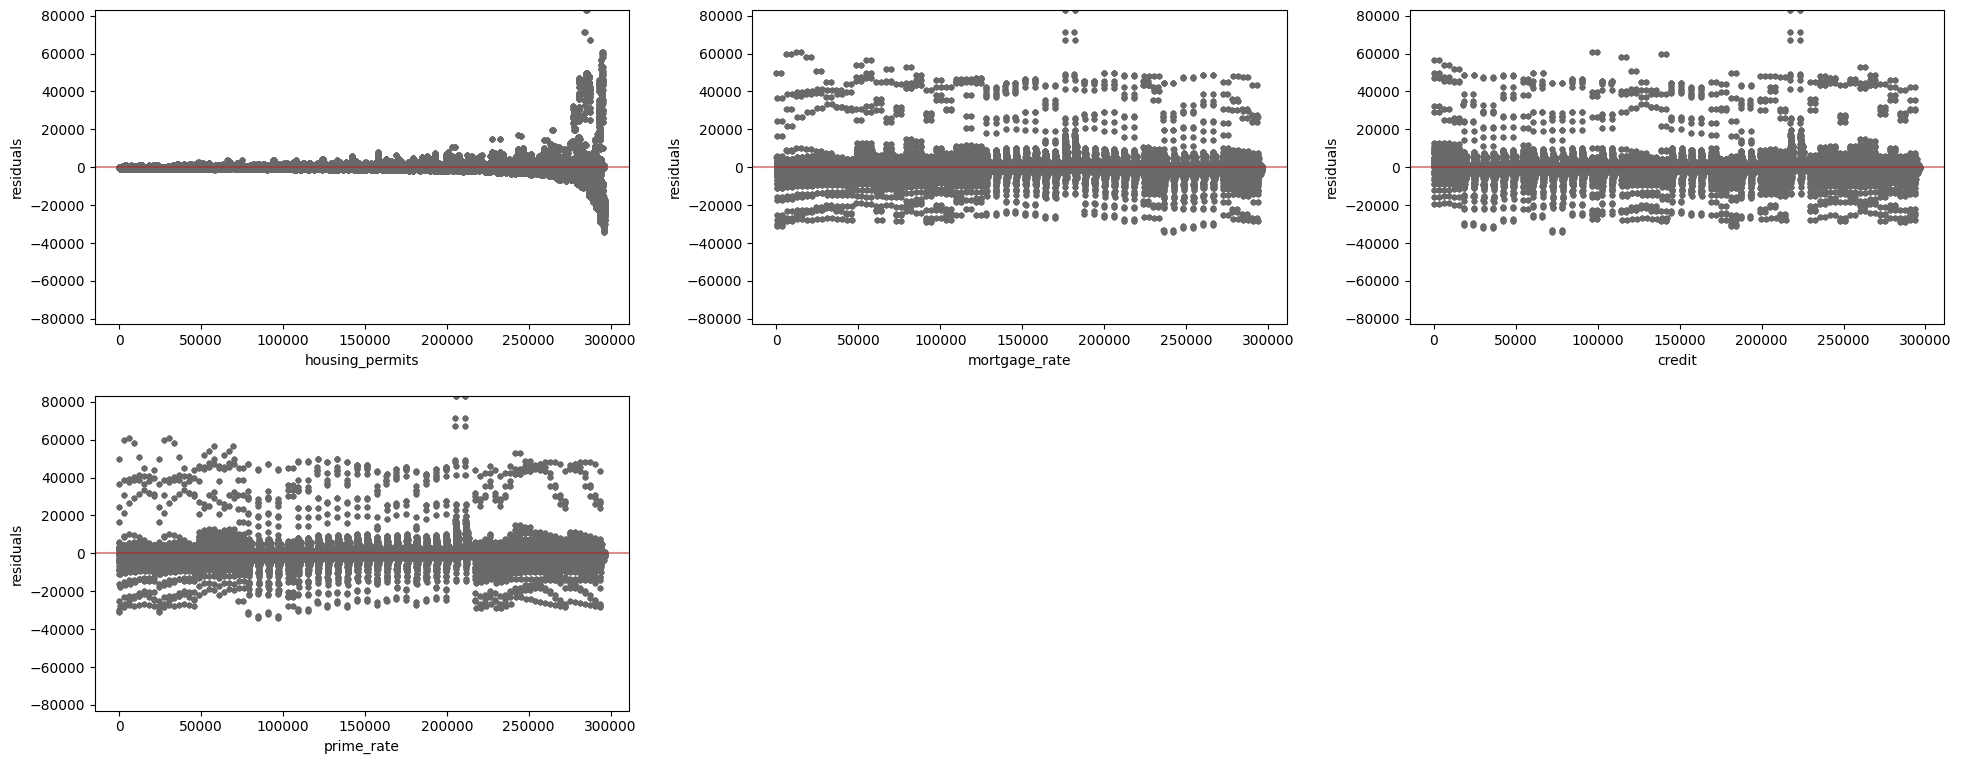

In [13]:
residuals2 = hp.plot_residuals(data = df, result = result2, variables= ['housing_permits', 'mortgage_rate', 'credit', 'prime_rate'])

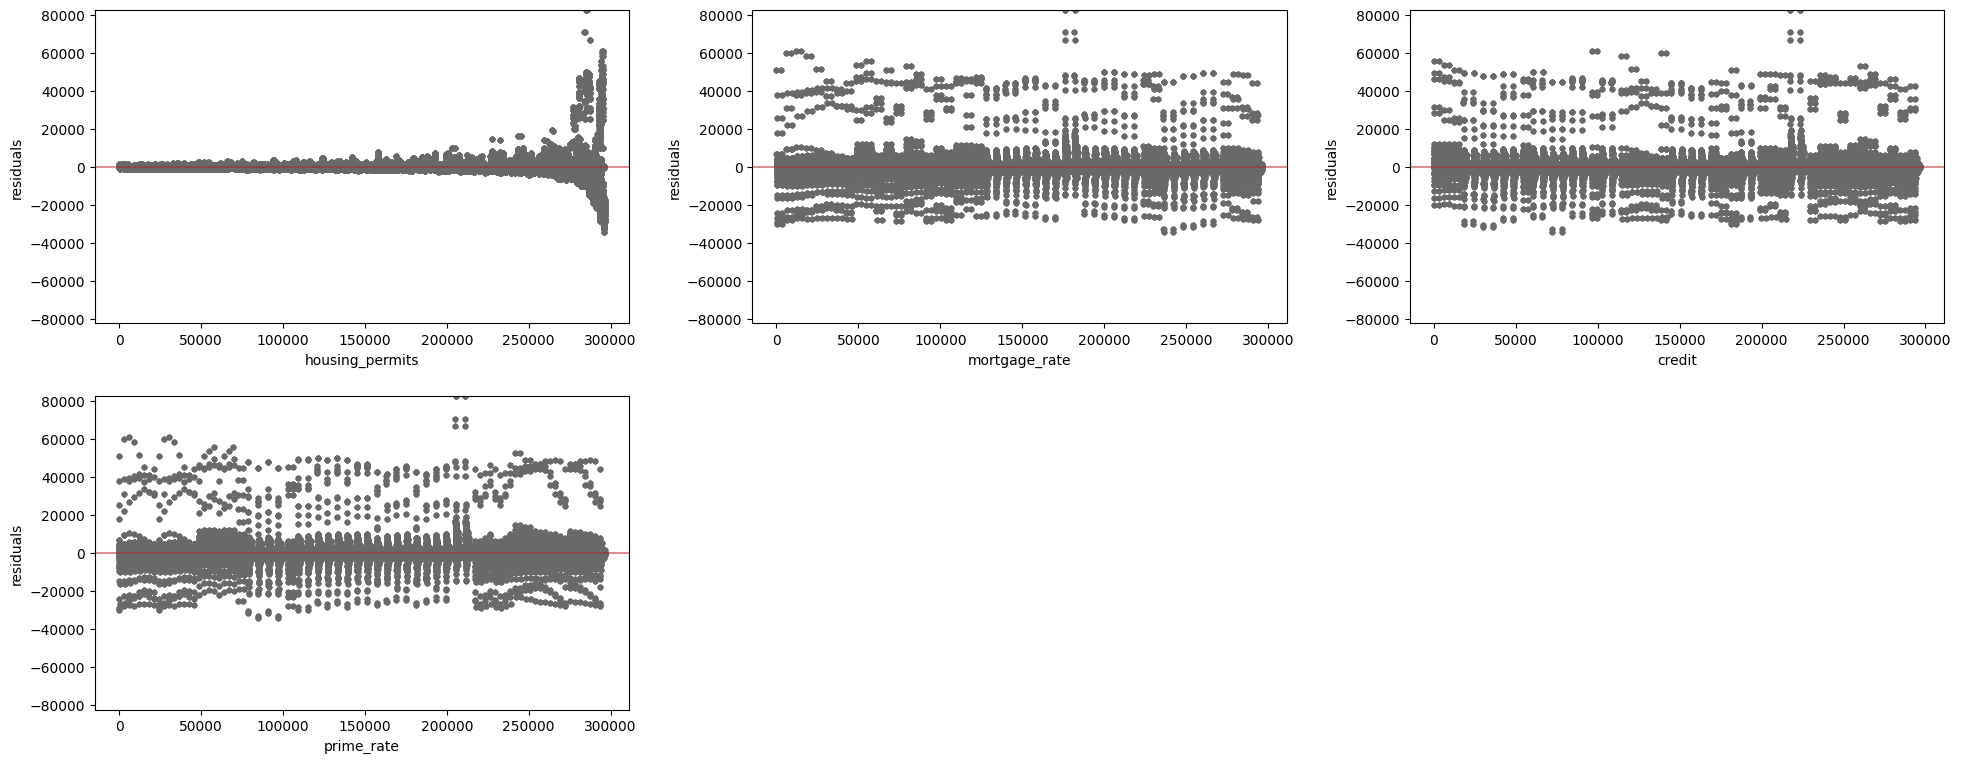

In [14]:
residuals4 = hp.plot_residuals(data = df, result = result4, variables= ['housing_permits', 'mortgage_rate', 'credit', 'prime_rate'])

The general shapes of all four residual plots is very similar as before. Although it's not theoretically ideal (WLS is a better course of action), let's try a transform on `housing_permits` to see we can improve the $R^2$

## 3.1e Linear Model Development

Let's try taking the natural log of the permits to see how that affects everything.

In [15]:
df['lg_housing_permits'] = np.log(df['housing_permits'])
model5 = 'housing_inventory ~ lg_housing_permits + mortgage_rate + credit + prime_rate + mortgage_rate:prime_rate + mortgage_rate:credit + prime_rate:credit + mortgage_rate:prime_rate:credit'
result5 = hp.bootstrap_linear_regression(formula=model5, data = df)
hp.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,7006.61,6532.50,7392.65
housing_permits,$\beta_{1}$,10.37,10.26,10.51
mortgage_rate,$\beta_{2}$,-10112.61,-11218.03,-9047.29
credit,$\beta_{3}$,-0.04,-0.04,-0.04
prime_rate,$\beta_{4}$,36158.04,33996.66,37778.28
mortgage_rate:prime_rate,$\beta_{5}$,-7209.59,-7625.05,-6705.38
mortgage_rate:credit,$\beta_{6}$,0.02,0.02,0.02
prime_rate:credit,$\beta_{7}$,-0.03,-0.03,-0.03
mortgage_rate:prime_rate:credit,$\beta_{8}$,0.01,0.00,0.01


Well this was not the direction to go at all! Our error went up dramatically, and our $R^2$ plummeted.

Let's revert and try one last course of action focused on transforming credit since it has had such a low influence (looking at its coefficients) and since it is an innately country aggregate value per month that might require some transforms to better reflect its true influence.

## 3.1f Linear Model Development

Perhaps transforming the aggregate credit value will improve our model. Let's try it out.

In [16]:
df['lg10_credit']= np.log10(df['credit'])
model6 = 'housing_inventory ~ housing_permits + mortgage_rate + lg10_credit + prime_rate + mortgage_rate:prime_rate + mortgage_rate:lg10_credit + prime_rate:lg10_credit + mortgage_rate:prime_rate:lg10_credit'
result6 = hp.bootstrap_linear_regression(formula=model6, data = df)
hp.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,5831.88,5311.54,6466.81
lg_housing_permits,$\beta_{1}$,3037.19,3001.04,3070.95
mortgage_rate,$\beta_{2}$,-12636.75,-14029.61,-11073.92
credit,$\beta_{3}$,-0.05,-0.06,-0.05
prime_rate,$\beta_{4}$,34309.34,31664.48,36774.43
mortgage_rate:prime_rate,$\beta_{5}$,-6713.76,-7341.17,-6216.17
mortgage_rate:credit,$\beta_{6}$,0.02,0.02,0.02
prime_rate:credit,$\beta_{7}$,-0.03,-0.03,-0.02
mortgage_rate:prime_rate:credit,$\beta_{8}$,0.00,0.00,0.01


Unfortunately, this did not improve our model, the error went up again, but at least the $R^2$ remained consistent.

## 3.2a Describe the final model

Let's use model4,
```
'housing_inventory ~ housing_permits + mortgage_rate + credit + prime_rate + mortgage_rate:prime_rate + mortgage_rate:credit + prime_rate:credit + mortgage_rate:prime_rate:credit'
```
As our best model for this analysis. Let's rerun model4 so we have the information handy.

In [17]:
hp.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,7006.61,6532.50,7392.65
housing_permits,$\beta_{1}$,10.37,10.26,10.51
mortgage_rate,$\beta_{2}$,-10112.61,-11218.03,-9047.29
credit,$\beta_{3}$,-0.04,-0.04,-0.04
prime_rate,$\beta_{4}$,36158.04,33996.66,37778.28
mortgage_rate:prime_rate,$\beta_{5}$,-7209.59,-7625.05,-6705.38
mortgage_rate:credit,$\beta_{6}$,0.02,0.02,0.02
prime_rate:credit,$\beta_{7}$,-0.03,-0.03,-0.03
mortgage_rate:prime_rate:credit,$\beta_{8}$,0.01,0.00,0.01


Looking at our final model that abstracts away from specific `cbsa_code`s,:
$$\hat{y}=79342.25 + 10.37 \beta_1 - 29330.08 \beta_2 - 0.11 \beta_3 + 17737.31 \beta_4 - 2339.83 \beta_5 + 0.04 \beta_6  - 0.01 \beta_7$$

- $\beta_0$ = the intercept of 79,342 represents the constant estimate of the housing inventory if all other factors are zero.
- $\beta_1$ = the coefficient of 10.37 means the housing inventory increases 10.37 for every permit that is issued; this is a little counterintuitive as clearly a single permit strictly has a 1-1 relationship with actual housing inventory. However, the issuance of a permit is a leading indicator for future housing inventory numbers. This coefficient effectively compresses the time effect into a single contemporary estimate. Restated from this data set, we can infer than each permit issued is a very strong indicator of future housing inventory
- $\beta_2$ = the coefficient of -29,330 means that for every point of increase in the mortgage rate interest the housing inventory decreases by 29,330 units; this makes sense a full point of mortgage interest on a $\$$500,000$ home loan would result in an additional $\$$417$ per month of mortgage interest payment. Accordingly, people would be less inclined to buy. Initially this might produce an actual increase in inventory, but over time that mortgage point increase would likely cause the reduction as builders would stop building, and sellers, not finding buyers, would either take their homes off the market or sell at a loss.
- $\beta_3$ = the coefficient of -0.11 means that for every increase in every million dollars of revolving credit (the unit used in the revolving credit data), the housing inventory would decrease by 0.11 house.
- $\beta_4$ = the coefficient of 17,737 means that for every increase in the prime rae percentage, the number of housing inventory increases by 17,737. This is counter-intuitive as the prime-rate is often erroneously directly tied to the mortgage rate, and this dataset shows that is not the case.
- $\beta_5$ = the coefficient of interaction term between the mortgage rate and the prime rate is -2,339; this means for every unit increase the product of the two rates, the housing inventory reduces by 2,339 units.
- $\beta_6$ = the coefficient of the interaction term between the mortgage rate and the millions of revolving credit is 0.04; this means for every unit increase in product of the mortgage rate and million dollars of revolving credit, the housing inventory increases by 0.04.
- $\beta_7$ = the coefficient of the interaction term between the prime rate and the millions of revolving credit is -0.01; this means for every unit of the increase in the product of the prime rate and millions of revolving credit, the available housing reduces by 0.01
- $\beta_8$ =  the coefficient of the interaction term between the mortgage_rate, prime_rate, and millions of revolving credit is 0; this means that there is no affect when these three and looked at as a composite fact; accordingly it is left out of the final model.


## 3.2b Describe the final model

Let's use cross-validation to check the bounds on the final model.


In [18]:
cv_results = hp.cross_validation(algorithm=hp.linear_regression, formula=model4, data=df, repetitions=5)

print('Our 95% credible interval for these 50 values for the error is:\n\t {a}'.format(a=stats.mstats.mquantiles(cv_results['sigma_metric'],[0.025, 0.975])))
print('Our 95% credible interval for these 50 values for the R^2 is: \n\t {a}'.format(a=stats.mstats.mquantiles(cv_results['r2_metric'],[0.025, 0.975])))

Our 95% credible interval for these 50 values for the error is:
	 [4981.81345162 5331.00961452]
Our 95% credible interval for these 50 values for the R^2 is: 
	 [0.58010442 0.61956427]


Above, we can the cross-validation results across 50 simulations to see what our credible intervals for both the error and $R^2$ for our final model. While our error is fairly tightly bound, the $R^2$ barely gets into the acceptable range. The heteroscedasticity of the housing permits data is the most likely culprit.

## 4 Use the Model

To recap, our null model predicts we should expect the following housing inventory:


In [19]:
null = np.mean(df['housing_inventory'])
sd = np.std(df['housing_inventory'])

print("Null model predicts {a} houses".format(a=round(null, 5)))
print("With a theoretical 95% error bounds of {a} houses - {b} houses".format(a = round(null - 1.96 * sd,5), b = round(null + 1.96 * sd, 5 )))
print("Or a more practical95% error bounds of {a} houses - {b} houses".format(a = round(0,5), b = round(null + 1.96 * sd, 5 )))

Null model predicts 3634.1596 houses
With a theoretical 95% error bounds of -12395.53644 houses - 19663.85564 houses
Or a more practical95% error bounds of 0 houses - 19663.85564 houses


Now, let's use the linear model we developed to make some predictions.

## 4a. Prediction 1

First, let's find the predicted housing inventory for 5,000 building permits in a notional location (aka, no particular cbsa location), a mortgage rate of 2.0%, revolving credit of 750,000 millions, and a prime rate of 4.0%.

In [20]:
final_sd = result4['sigma']

permits, mortgage_interest, revolve_credit_M, prime_interest, = 5000, 0.02, 750000, 0.04
query_list = [1, permits, mortgage_interest, revolve_credit_M, prime_interest, mortgage_interest * prime_interest,
              mortgage_interest * revolve_credit_M, prime_interest * revolve_credit_M, 0]
prediction = result4['model'].predict([query_list])[0][0]

print("Linear model predicts {} houses".format(round(prediction, 5)))
print("With a 95% error bounds of {a} houses - {b} houses".format(a=round(prediction - 1.96 * sd, 5),
                                                                  b=round(prediction + 1.96 * sd, 5)))


Linear model predicts 28123.20408 houses
With a 95% error bounds of 12093.50804 houses - 44152.90012 houses


This prediction aligns with intuition as it is well within the bounds of our data range.

## 4b Prediction 2

Second, let's find the predicted housing inventory if we go beyond the far range of our data with 15,000 building permits, a mortgage rate of 10.0%, 1 billion millions in revolving credit, and a prime-rate of 8.0%. This is way off the charts into extrapolation; so, it will be interesting to see what the predicted housing inventory is.

In [21]:
permits, mortgage_interest, revolve_credit_M, prime_interest, = 15000, 0.10, 10000000, 0.08
query_list = [1, permits, mortgage_interest, revolve_credit_M, prime_interest, mortgage_interest * prime_interest,
              mortgage_interest * revolve_credit_M, prime_interest * revolve_credit_M, 0]
prediction = result4['model'].predict([query_list])[0][0]

print("Linear model predicts {} houses".format(round(prediction, 5)))
print("With a 95% error bounds of {a} houses - {b} houses".format(a=round(prediction - 1.96 * sd, 5),
                                                                  b=round(prediction + 1.96 * sd, 5)))

Linear model predicts -257649.60322 houses
With a 95% error bounds of -273679.29926 houses - -241619.90719 houses


This prediction is not realistic as it illustrates what happens if we extrapolate too far beyond the range of our dataset.

## 4c Prediction 3

Third, let's see what happens if we go to the other extreme and predict the housing inventory with 1 building permit, a mortgage rate of 0.5%, 1 million in revolving credit, and a prime rate of 0% (banks are just literally giving money away).

In [22]:
permits, mortgage_interest, revolve_credit_M, prime_interest, = 1, 0.05, 1, 0
query_list = [1, permits, mortgage_interest, revolve_credit_M, prime_interest, mortgage_interest * prime_interest,
              mortgage_interest * revolve_credit_M, prime_interest * revolve_credit_M, 0]
prediction = result4['model'].predict([query_list])[0][0]

print("Linear model predicts {} houses".format(round(prediction, 5)))
print("With a 95% error bounds of {a} houses - {b} houses".format(a=round(prediction - 1.96 * sd, 5),
                                                                  b=round(prediction + 1.96 * sd, 5)))

Linear model predicts 6511.31325 houses
With a 95% error bounds of -9518.38279 houses - 22541.00929 houses


Interesting, this estimate is lower than intuitively expected as well off of the highest value in our observed data, 108,702 houses. Perhaps the single building permit dragged things down a bit.


## 4d Prediction 4

Fourth, let's try to maximize the situation by bumping up the housing permits a bit by taking the situation in prediction 3 and making the housing permits 5,000 for the month. We would expect this to be pretty close our maximum value observed in the dataset.


In [23]:
permits, mortgage_interest, revolve_credit_M, prime_interest, = 5000, 0.05, 1, 0
query_list = [1, permits, mortgage_interest, revolve_credit_M, prime_interest, mortgage_interest * prime_interest,
              mortgage_interest * revolve_credit_M, prime_interest * revolve_credit_M, 0]
prediction = result4['model'].predict([query_list])[0][0]

print("Linear model predicts {} houses".format(round(prediction, 5)))
print("With a 95% error bounds of {a} houses - {b} houses".format(a=round(prediction - 1.96 * sd, 5),
                                                                  b=round(prediction + 1.96 * sd, 5)))

Linear model predicts 58361.11567 houses
With a 95% error bounds of 42331.41964 houses - 74390.81171 houses


Success! While rates are unrealistic, we've succeeded in hitting a new high value for the housing inventory for the month, 129,735! The most unrealistic parameters to this scenario, pragmatically, is the prime rate being 0 and the revolving credit being only 1 million. If banks were really extending free money to the customers (like the federal banking system has been doing for central banks since about April 2020 to Dec 2021), folks would likely be running up massive sums of interest free credit debt.[2]

## 4e Prediction 5

For our final prediction, let's revise the situation from prediction 4 to reflect people running up massive debt. So, instead of 1 million of revolving credit, let's make it double the max of our highest observed credit or 1091988*2 = 2,183,976 millions. We would expect this to case the housing inventory to dip substantially over our prediction 4.

In [24]:
permits, mortgage_interest, revolve_credit_M, prime_interest, = 5000, 0.05, 2183976, 0
query_list = [1, permits, mortgage_interest, revolve_credit_M, prime_interest, mortgage_interest * prime_interest,
              mortgage_interest * revolve_credit_M, prime_interest * revolve_credit_M, 0]
prediction = result4['model'].predict([query_list])[0][0]

print("Linear model predicts {} houses".format(round(prediction, 5)))
print("With a 95% error bounds of {a} houses - {b} houses".format(a=round(prediction - 1.96 * sd, 5),
                                                                  b=round(prediction + 1.96 * sd, 5)))

Linear model predicts -31047.68858 houses
With a 95% error bounds of -47077.38462 houses - -15017.99254 houses


Well, that was a greater dip than expected! Deep into the negative territory. Practically, this is impossible; however, it does illustrate how consumer debt can dramatically influence the model. Interestingly, and first glance, the coefficient for credit, $beta_3$ is only -0.11; so, it might not immediately stand out as something that would dramatically influence the housing inventory. However, this value is millions aggregated across all households per month. In the United Sates, this is a massive multiplier; hence, revolving credit has a substantial influence on the overall housing inventory per month.

---
[1] Balaban, J. (2018, August 27). When and How to use Weighted Least Squares (WLS) Models. Medium. Retrieved December 4, 2021, from https://towardsdatascience.com/when-and-how-to-use-weighted-least-squares-wls-models-a68808b1a89d

[2]Federal Bank St. Louis. (2021, December 1). FRED Economic Data. FRED Economic Data. Retrieved December 6, 2021, from https://fred.stlouisfed.org/series/FEDFUNDS